In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [ ]:
!git clone https://github.com/ieee8023/covid-chestxray-dataset.git

Cloning into 'covid-chestxray-dataset'...
remote: Enumerating objects: 71, done.
remote: Counting objects: 100% (71/71), done.
remote: Compressing objects: 100% (54/54), done.
remote: Total 3204 (delta 30), reused 49 (delta 17), pack-reused 3133
Receiving objects: 100% (3204/3204), 582.58 MiB | 39.98 MiB/s, done.
Resolving deltas: 100% (1266/1266), done.
Checking out files: 100% (991/991), done.


In [ ]:
!mkdir -p /content/dataset/covid/
!mkdir -p /content/dataset/normal/
!mkdir -p /content/dataset/pneumonia/

In [ ]:
!unzip "/content/drive/My Drive/Datasets/Chest X-Ray Images (Pneumonia).zip"

Le flux de sortie a été tronqué et ne contient que les 5000 dernières lignes.
  inflating: chest_xray/train/NORMAL/IM-0435-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0437-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0438-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001-0002.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0439-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0440-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0441-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0442-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0444-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0445-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0446-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0447-0001.jpeg  
  inflating: chest_xray/train/NORMAL/IM-0448-00

In [ ]:
!mv /content/chest_xray/train/NORMAL/* /content/dataset/normal/
!mv /content/chest_xray/train/PNEUMONIA/* /content/dataset/pneumonia/
!mv /content/chest_xray/val/NORMAL/* /content/dataset/normal/
!mv /content/chest_xray/val/PNEUMONIA/* /content/dataset/pneumonia/
!mv /content/chest_xray/test/NORMAL/* /content/dataset/normal/
!mv /content/chest_xray/test/PNEUMONIA/* /content/dataset/pneumonia/

In [ ]:
import pandas as pd
import shutil
import os

# Selecting all combination of 'COVID-19' patients with 'PA' X-Ray view
virus = "COVID-19" # Virus to look for
x_ray_view = "PA" # View of X-Ray

meta_data = "/content/covid-chestxray-dataset/metadata.csv"
images_dir = "/content/covid-chestxray-dataset/images"
output_dir = "/content/dataset/covid/"

metadata_csv = pd.read_csv(meta_data)

for (i, row) in metadata_csv.iterrows():
	if row["finding"] != virus or row["view"] != x_ray_view:
		continue

	filename = row["filename"].split(os.path.sep)[-1]
	filePath = os.path.sep.join([images_dir, filename])
	shutil.copy2(filePath, output_dir)

  ## Pre-processing 

In [ ]:
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator,load_img, img_to_array
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D,GlobalAveragePooling2D
from keras.layers import Input, average, Average
from keras.layers import Activation, Dropout, BatchNormalization, Flatten, Dense

from keras.models import Sequential, Model
from keras.applications.xception import Xception
from keras.applications.resnet50 import ResNet50
from keras.applications import ResNet101
from keras.applications import DenseNet201
from keras.applications import MobileNet
from keras.applications.vgg16 import VGG16, preprocess_input
from keras.optimizers import Adam, SGD, RMSprop

import tensorflow as tf

import os
import numpy as np
import pandas as pd
import time

import random

from PIL import Image
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

In [ ]:
DATASET_DIR = "/content/dataset"

NORMAL_DIR = DATASET_DIR + "/normal"
PNEUMONIA_DIR = DATASET_DIR + "/pneumonia"
COVID_DIR = DATASET_DIR + "/covid"


IMG_W = 224
IMG_H = 224
IMG_C = 1
INPUT_SHAPE = (IMG_W, IMG_H, IMG_C)

CLASSES = [ "NORMAL", "PNEUMONIA", "COVID" ]
NB_CLASSES = len(CLASSES)

EPOCHS = 5
BATCH_SIZE = 8

In [ ]:
normal_images = []
pneumonia_images = []
covid_images = []

In [ ]:
for img_path in glob.glob(NORMAL_DIR + '/*'):
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_H,IMG_H))
    img = np.asarray(img)
    normal_images.append(img[:np.newaxis])

for img_path in glob.glob(PNEUMONIA_DIR + '/*'):
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_H,IMG_H))
    img = np.asarray(img)
    pneumonia_images.append(img[:np.newaxis])

for img_path in glob.glob(COVID_DIR + '/*'):
    img = Image.open(img_path).convert('L')
    img = img.resize((IMG_H,IMG_H))
    img = np.asarray(img)
    covid_images.append(img[:np.newaxis])

In [ ]:
len(normal_images), len(pneumonia_images), len(covid_images)

(1583, 4273, 201)

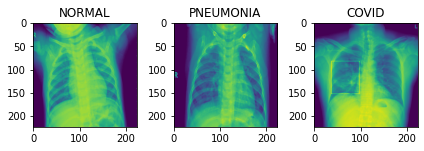

In [ ]:
width=150
height=150
rows = 1
cols = 3

imgs = [ normal_images[0], pneumonia_images[0], covid_images[0]]

axes=[]
fig=plt.figure()

for i in range(rows*cols):
    img = imgs[i]
    axes.append( fig.add_subplot(rows, cols, i+1) )
    plt.imshow(img)

axes[0].set_title('NORMAL')
axes[1].set_title('PNEUMONIA')
axes[2].set_title('COVID')
fig.tight_layout()    
plt.show()

In [ ]:
X = []
y = []

for item in normal_images:
    img = np.asarray(item)
    img = img.reshape(INPUT_SHAPE)
    X.append(img)    
    y.append(CLASSES.index("NORMAL"))

for item in pneumonia_images:
    img = np.asarray(item)
    img = img.reshape(INPUT_SHAPE)
    X.append(img)    
    y.append(CLASSES.index("PNEUMONIA"))

for item in covid_images:
    img = np.asarray(item)
    img = img.reshape(INPUT_SHAPE)
    X.append(img)    
    y.append(CLASSES.index("COVID"))

X = np.asarray(X)
y = np.asarray(y)

In [ ]:
X.shape, y.shape

((6057, 224, 224, 1), (6057,))

In [ ]:
from sklearn.model_selection import train_test_split
# X_train, X_test, y_train, y_test = train_test_split(
#     X, y, test_size=0.2, random_state=2020)


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=1) # 0.25 x 0.8 = 0.2


In [ ]:
X_train = np.repeat(X_train[...,], 3, 3)
X_val = np.repeat(X_val[...,], 3, 3)
X_test = np.repeat(X_test[...,], 3, 3)

In [ ]:
X_train.shape, y_train.shape

((3633, 224, 224, 3), (3633,))

In [ ]:
X_test.shape, y_test.shape

((1212, 224, 224, 3), (1212,))

In [ ]:
np.unique(y_train, return_counts=True)

(array([0, 1, 2]), array([ 936, 2569,  128]))

In [ ]:
np.unique(y_test, return_counts=True)

(array([0, 1, 2]), array([309, 862,  41]))

In [ ]:
from keras.utils import to_categorical

y_train = to_categorical(y_train)
y_val = to_categorical(y_val)
y_test = to_categorical(y_test)

In [ ]:
# model = Sequential()
# model.add(Conv2D(32, (3, 3), input_shape=INPUT_SHAPE))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(32, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Conv2D(64, (3, 3)))
# model.add(Activation('relu'))
# model.add(MaxPooling2D(pool_size=(2, 2)))

# model.add(Flatten())
# model.add(Dense(64))
# model.add(Activation('relu'))
# model.add(Dropout(0.5))
# model.add(Dense(NB_CLASSES))
# model.add(Activation('softmax'))

In [ ]:
vgg_model = VGG16(weights='imagenet', 
                        include_top=False, 
                        input_shape=(IMG_H, IMG_W, 3))

for layer in vgg_model.layers:
    if isinstance(layer, BatchNormalization):
        layer.trainable = True
    else:
        layer.trainable = False

model = Sequential()
model.add(vgg_model)
model.add(GlobalAveragePooling2D())
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.5))
model.add(BatchNormalization())
model.add(Dense(NB_CLASSES, activation='softmax'))

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

In [ ]:
model.summary()

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
global_average_pooling2d_2 ( (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dense_8 (Dense)              (None, 3)                 771       
Total params: 14,847,811
Trainable params: 132,611
Non-trainable params: 14,715,200
____________________________________

In [ ]:
hist = model.fit(X_train, 
                 y_train, 
                 batch_size=BATCH_SIZE, 
                 epochs=3, 
                 verbose=1, 
                 callbacks=None, 
                 validation_data=(X_val, y_val))

Train on 3633 samples, validate on 1212 samples
Epoch 1/3
3633/3633 [==============================] - 2389s 658ms/step - loss: 0.4033 - accuracy: 0.8459 - val_loss: 0.1960 - val_accuracy: 0.9332
Epoch 2/3
3633/3633 [==============================] - 2387s 657ms/step - loss: 0.2914 - accuracy: 0.8874 - val_loss: 0.1704 - val_accuracy: 0.9431
Epoch 3/3
3633/3633 [==============================] - 2382s 656ms/step - loss: 0.2590 - accuracy: 0.8995 - val_loss: 0.1829 - val_accuracy: 0.9447


In [ ]:
model.evaluate(X_test, y_test)

1212/1212 [==============================] - 597s 492ms/step


[0.17786741846858864, 0.9529703259468079]

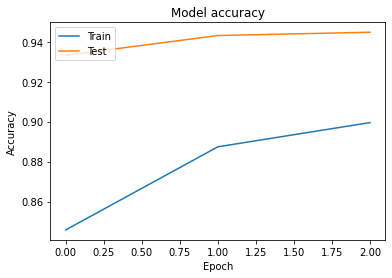

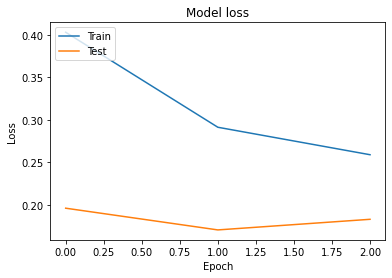

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
import itertools

# Plot training & validation accuracy values
plt.plot(hist.history['accuracy'])
plt.plot(hist.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
# Confusion matrix
# Credit: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
from sklearn.metrics import confusion_matrix
import itertools

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
  
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        cm = np.round(cm, 2)

    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


In [ ]:
Y_pred = model.predict(X_test)
Y_pred_classes = np.argmax(Y_pred,axis = 1) 
Y_true = np.argmax(y_test,axis = 1) 
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes) 

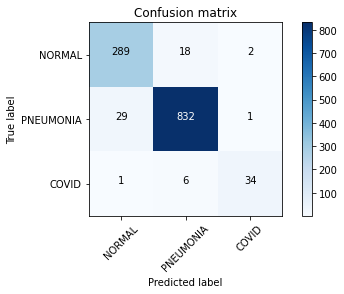

In [ ]:
plot_confusion_matrix(confusion_mtx, classes = CLASSES)

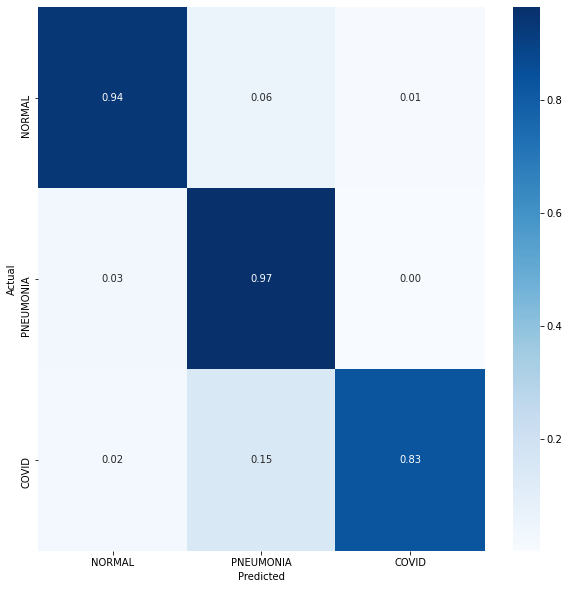

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# plot_confusion_matrix(confusion_mtx, classes = CLASSES, normalize=True)
conf_mat = confusion_matrix(Y_true, Y_pred_classes)
# Normalise
conf_mat_norm = conf_mat.astype('float') / conf_mat.sum(axis=1)[:, np.newaxis]
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat_norm, annot=True, cmap=plt.cm.Blues, fmt='.2f', xticklabels=CLASSES, yticklabels=CLASSES)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show(block=False)


In [ ]:
model.save_weights('Covid19_Detection_pretrained_VGG_3_Epochs.h5')

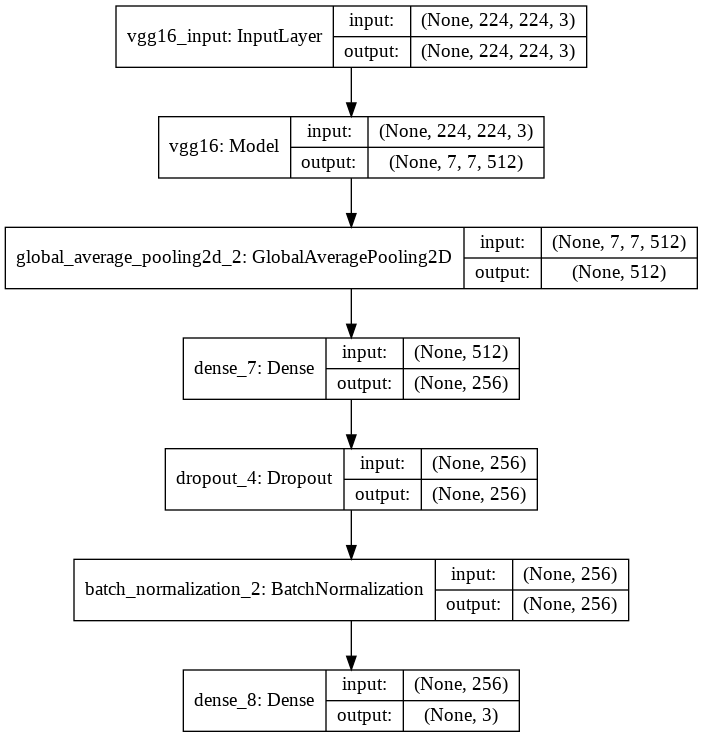

In [ ]:
from keras.utils import plot_model
plot_model(model, show_shapes=True, to_file='Covid19_Detection_pretrained_VGG_3_Epochs.png')